# 4-way Comparison
The purpose of this notebook is to compare the binomial tree (BT), Longstaff-Shwartz (LS), Approximate Dynamic Programming (ADP), and Reinforcement Learning (RL). We consider both the pricing of vanilla american put and call options. We also compare our solution to that of Black-Scholes (BS) for European put and call option pricing.

In [1]:
# should permanantly add this path to pythonpath instead
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book') # clone the RL-book repo and put its path here
import matplotlib.pyplot as plt
####

from dataclasses import dataclass, replace
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import MarkovDecisionProcess, State, Terminal, NonTerminal
from rl.policy import FiniteDeterministicPolicy, DeterministicPolicy
from rl.distribution import Constant, Categorical, SampledDistribution
from rl.finite_horizon import optimal_vf_and_policy
from modified_rl_book_code.function_approx_fred import FunctionApprox, LinearFunctionApprox, LinearInterpolationApprox,\
                                 BSplineApprox, AdamGradient  # TODO: "Change to not fred?
from modified_rl_book_code.approximate_dynamic_programming_fred import back_opt_vf_and_policy # TODO: Change to not fred?
from rl.gen_utils.plot_funcs import plot_list_of_curves
from numpy.polynomial.laguerre import lagval
from scipy.stats import norm
from time import time

TrainingDataType = Tuple[int, float, float]

## Helper Classes and Functions

### European Option Pricing using Black-Scholes

In [2]:
def european_price(is_call: bool, strike: float, vol: float, expiry: float,
                   spot_price: float, rate: float) -> float:
    """
    Compute the price of an european option (put or call) computed using BS solution.
    """
    sigma_sqrt: float = vol * np.sqrt(expiry)
    d1: float = (np.log(spot_price / strike) +
                 (rate + vol ** 2 / 2.) * expiry) \
        / sigma_sqrt
    d2: float = d1 - sigma_sqrt
    if is_call:
        ret = spot_price * norm.cdf(d1) - \
            strike * np.exp(-rate * expiry) * norm.cdf(d2)
    else:
        ret = strike * np.exp(-rate * expiry) * norm.cdf(-d2) - \
            spot_price * norm.cdf(-d1)
    return ret

### American Option Pricing using Binomial Tree

In [3]:
@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 

    def dt(self) -> float:
        """
        Get the time interval size used for discretization 
        """
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        """
        Get the price associated with state j of time step i.
        """
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FiniteDeterministicPolicy[int, bool]]]:
        """
        Compute the optimal value functions and optimal policies for each time step by backward induction.
        """
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        # this step calls this function from the finite_horizon module.
        return optimal_vf_and_policy( 
            steps=[
                {NonTerminal(j): {
                    True: Constant(
                        (
                            Terminal(-1),
                            self.payoff(self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (NonTerminal(j + 1), 0.): up_prob,
                            (NonTerminal(j),     0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FiniteDeterministicPolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].action_for[j] and
                         self.payoff(self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, self.state_price(i, boundary_pt))
                )
        return ex_boundary

    
    

### American Option Pricing using Approximate Dynamic Programming

In [4]:
# (almost) original code using linear function approximation
@dataclass(frozen=True)
class OptimalExerciseADP:
    '''Optimal Exercise with Backward Induction when the underlying
    price follows a lognormal process'''

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float
    num_state_samples: int
    num_expectation_samples: int

    def get_mdp(self, t: int) -> MarkovDecisionProcess[float, bool]:
        dt: float = self.expiry / self.num_steps
        exer_payoff: Callable[[float], float] = self.payoff
        r: float = self.rate
        s: float = self.vol

        class OptExerciseADPMDP(MarkovDecisionProcess[float, bool]):
            
            def __init__(self, num_state_samples, num_expectation_samples):
                self.num_state_samples = num_state_samples
                self.num_expectation_samples = num_expectation_samples
        
            def step(
                self,
                price: NonTerminal[float],
                exer: bool
            ) -> SampledDistribution[Tuple[State[float], float]]:

                def sr_sampler_func(
                    price=price,
                    exer=exer
                ) -> Tuple[State[float], float]:
                    if exer:
                        return Terminal(0.), exer_payoff(price.state)
                    else:
                        next_price: float = np.exp(np.random.normal(
                            np.log(price.state) + (r - s * s / 2) * dt,
                            s * np.sqrt(dt)
                        ))
                        return NonTerminal(next_price), 0.

#                 num_expectation_samples = 200
                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=self.num_expectation_samples # 200
                )

            def actions(self, price: NonTerminal[float]) -> Sequence[bool]:
                return [True, False]

        return OptExerciseADPMDP(self.num_state_samples, self.num_expectation_samples)

    
    # this method is only used once in the method backward_induction_vf_and_pi. It is used 
    # to sample the states to sample to make the updates to the ADP function approx.
    # I would like to have it sample a few more outliers because the function approximation
    # tends to overfit the sample that are in a high density region. 
    def get_states_distribution( 
        self,
        t: int
    ) -> SampledDistribution[NonTerminal[float]]:
        spot_mean2: float = self.spot_price * self.spot_price
        spot_var: float = spot_mean2 * \
            self.spot_price_frac * self.spot_price_frac
        log_mean: float = np.log(spot_mean2 / np.sqrt(spot_var + spot_mean2))
        log_stdev: float = np.sqrt(np.log(spot_var / spot_mean2 + 1))

        time: float = t * self.expiry / self.num_steps

        def states_sampler_func() -> NonTerminal[float]:
            start: float = np.random.lognormal(log_mean, log_stdev) 
            price = np.exp(np.random.normal(
                np.log(start) + (self.rate - self.vol * self.vol / 2) * time,
                self.vol * np.sqrt(time)
#                 self.vol * np.sqrt(time)*1.1  # I modified this line to have more variance (added the *1.1)
            ))
            return NonTerminal(price)

        return SampledDistribution(states_sampler_func)
    

    def get_vf_func_approx(
        self,
        t: int,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> LinearFunctionApprox[NonTerminal[float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            regularization_coeff=reg_coeff,
            direct_solve=True
        )

    def backward_induction_vf_and_pi(
        self,
        features: Sequence[Callable[[NonTerminal[float]], float]],
        reg_coeff: float
    ) -> Iterator[
        Tuple[FunctionApprox[NonTerminal[float]],
              DeterministicPolicy[float, bool]]
    ]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[float, bool],
            FunctionApprox[NonTerminal[float]],
            SampledDistribution[NonTerminal[float]]
        ]] = [(
            self.get_mdp(t=i),
            self.get_vf_func_approx(
                t=i,
                features=features,
                reg_coeff=reg_coeff
            ),
            self.get_states_distribution(t=i)
        ) for i in range(self.num_steps + 1)]

#         num_state_samples: int = 1000 #1000

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=np.exp(-self.rate * self.expiry / self.num_steps),
            num_state_samples=self.num_state_samples,
            error_tolerance=1e-8, #TODO: remove
            mode = "put"
        )

    def optimal_value_curve(
        self,
        func: FunctionApprox[NonTerminal[float]],
        prices: Sequence[float]
    ) -> np.ndarray:
        return func.evaluate([NonTerminal(p) for p in prices])

    def exercise_curve(
        self,
        prices: Sequence[float]
    ) -> np.ndarray:
        return np.array([self.payoff(p) for p in prices])

    def put_option_exercise_boundary(
        self,
        opt_vfs: Sequence[FunctionApprox[NonTerminal[float]]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for vf in opt_vfs[:-1]:
            cp: np.ndarray = self.optimal_value_curve(
                func=vf,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret
    
    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths
    
    def option_price(
        self,
        scoring_data: np.ndarray,
        ex_boundary: np.ndarray
    ) -> float:
        num_paths: int = scoring_data.shape[0]
#         prices: np.ndarray = np.zeros(num_paths)
        prices = np.exp(-self.rate * self.expiry) * np.array([self.payoff(path[-1]) for path in scoring_data])
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                if path[step] <= ex_boundary[step]:
                    prices[i] = np.exp(-self.rate * t) * self.payoff(path[step])
                    step = self.num_steps + 1
                step += 1

        return np.average(prices)
    


### American Option Pricing using Longstaff-Shwartz

In [64]:
@dataclass(frozen=True)
class OptimalExerciseLS:
    
    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float # better name than spot_price_frac
    strike: float
       
    # TODO why do we have a spot_price_frac?
    # TODO verify that my process behaves correctly
    # TODO check that I get the same results as Prof Rao's original code
#     @memoize
    def _get_all_paths(
        self,
        spot_price_frac: float,
        num_paths: int,
        num_dt: int
    ) -> np.ndarray:
        dt = self.expiry / num_dt
        paths = np.empty([num_paths, num_dt + 1])
        spot = self.spot_price
        for i in range(num_paths):
#             start = max(0.001, np.random.normal(spot, spot * spot_price_frac))
            start = self.spot_price
            paths[i, 0] = start
            for t in range(num_dt):
                mean = np.log(paths[i,t]) + (self.rate - self.vol * self.vol / 2) * dt
                std  = self.vol * np.sqrt(dt) 
                paths[i, t + 1] = np.exp(np.random.normal(mean, std))
        return paths


    # TODO: verify that the discount I use is OK
    # TODO: may operations could be vectorized
    def get_price(
        self,
        num_dt: int,
        num_paths: int,
        feature_funcs: Sequence[Callable[[NonTerminal[float]], float]],
        reglr_coeff: float
    ) -> float:
        paths = self._get_all_paths(0.0, num_paths, num_dt)

        cashflow = np.array([self.payoff(paths[i,-1])
                             for i in range(num_paths)])
        dt = self.expiry / num_dt

        ex_boundary_price_range = (0,self.strike)  # TODO: this approach won't work for call options (no need for boundary in call 
                                           #       options) Also, this is hardcoded stike price. I did change the stprcs uses
                                            # below with path_values
        stprcs = np.arange(*ex_boundary_price_range)
        final = [(p, self.payoff(p)) for p in stprcs]
        ex_boundary = [max(p for p, e in final if e > 0)]
        vf_seq = [final]
        for step in range(num_dt - 1, 0, -1):
            """
            For each time slice t
            Step 1: collect X as features of (t, [S_0,.., S_t]) for those paths
            for which payoff(t, [S_0, ...., S_t]) > 0, and corresponding Y as
            the time-t discounted future actual cash flow on those paths.
            Step 2: Do the (X,Y) regression. Denote Y^ as regression-prediction.
            Compare Y^ versus payoff(t, [S_0, ..., S_t]). If payoff is higher,
            set cashflow at time t on that path to be the payoff, else set 
            cashflow at time t on that path to be the time-t discounted future
            actual cash flow on that path.
            """
            t = step * dt
            disc = np.exp(-self.rate * dt)
            cashflow = cashflow * disc
            payoff = np.array([self.payoff(paths[i,step]) for i in range(num_paths)])
            indices = [i for i in range(num_paths) if payoff[i] > 0]
            if len(indices) > 0:
                path_values = sorted([paths[i, step] for i in indices])
                x_vals = np.array([[f(NonTerminal(paths[i, step])) for f in feature_funcs] for i in indices])
                y_vals = np.array([cashflow[i] for i in indices])
                A_reg = x_vals.T @ x_vals + reglr_coeff * np.eye(x_vals.shape[1])
                b_reg = x_vals.T @ y_vals
#                 weights = np.linalg.lstsq(x_vals.T @ x_vals, y_vals, rcond=None)[0]
                weights = np.linalg.lstsq(A_reg, b_reg, rcond=None)[0]
                estimate = x_vals.dot(weights)
#                 plt.scatter([paths[i, step] for i in indices], y_vals, c='r')
#                 plt.scatter([paths[i, step] for i in indices], estimate, c='b')
#                 plt.plot([paths[i, step] for i in indices], [self.payoff(paths[i, step]) for i in indices], c='g')
#                 plt.show()

                for i, ind in enumerate(indices):
                    if payoff[ind] > estimate[i]:
                        cashflow[ind] = payoff[ind]

                cp = [weights.dot([f(NonTerminal(s)) for f in feature_funcs]) for s in path_values]
                ep = [self.payoff(s) for s in path_values]
                op = [(path_values[j],max(cp[j],ep[j])) for j in range(len(path_values))]
                vf_seq.append(op)
                ll = [p for p, c, e in zip(path_values, cp, ep) if e > c] 
                if len(ll) == 0:
                    num = 0. # TODO: check if the following lines that I added (instead of simply setting to 0, set to previous value)
#                     if len(ex_boundary) != 0:
#                         num = ex_boundary[-1]
#                     else:
#                         num = 0
                else:
                    num = max(ll)
                ex_boundary.append(num)
#                 # plot the continuation and exercise value functions at step step
#                 if step % 10 == 0:
#                     plt.title("LS Time = %.3f" % t)
#                     plt.scatter([paths[i, step] for i in indices], y_vals,s=5)
#                     plt.plot(path_values, cp, 'r', path_values, ep, 'b')
#                     plt.show()

        vf_seq.append([(self.spot_price,max(self.payoff(self.spot_price),np.average(cashflow * np.exp(-self.rate * dt))))])

        return max(
            self.payoff(self.spot_price),
            np.average(cashflow * np.exp(-self.rate * dt))
        ), ex_boundary[::-1], vf_seq[::-1] #TODO: I think I have reversed it
                       #TODO: only have the exercise boundary if it is a put option

        




### American Option Pricing using Reinforcement Learning

In [6]:

@dataclass(frozen=True)
class OptimalExerciseRL:

    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 
        
    def training_sim_data(
        self,
        num_paths: int,
        spot_price_frac: float
    ) -> Sequence[TrainingDataType]:
        ret: List[TrainingDataType] = []
        dt: float = self.expiry / self.num_steps
        spot: float = self.spot_price
        vol2: float = self.vol * self.vol

        mean2: float = spot * spot
        var: float = mean2 * spot_price_frac * spot_price_frac
        log_mean: float = np.log(mean2 / np.sqrt(var + mean2))
        log_stdev: float = np.sqrt(np.log(var / mean2 + 1))

        for i in range(num_paths):
            price: float = np.random.lognormal(log_mean, log_stdev)
            for step in range(self.num_steps):
                m: float = np.log(price) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                next_price: float = np.exp(np.random.normal(m, np.sqrt(v)))
                ret.append((step, price, next_price))
                price = next_price
        return ret
    
    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths
    
    def linear_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        reg: float
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )
    
    def adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.1,
            decay1=0.9,
            decay2=0.999
        )
    
    def train_lspi(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: LinearFunctionApprox[Tuple[float, float]],
        training_iters: int,
        split: int
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        fa: LinearFunctionApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        num_features: int = len(fa.feature_functions)
        states: Sequence[Tuple[float, float]] = [(i * dt, s) for
                                                 i, s, _ in training_data]
        next_states: Sequence[Tuple[float, float]] = \
            [((i + 1) * dt, s1) for i, _, s1 in training_data]
        features: np.ndarray = fa.get_feature_values(states)
        next_features: np.ndarray = fa.get_feature_values(next_states)
        non_terminal: np.ndarray = np.array(
            [i < self.num_steps - 1 for i, _, _ in training_data]
        )
        exer: np.ndarray = np.array([self.payoff(s1)
                                     for t1, s1 in next_states])
        reg_mat: np.ndarray = fa.regularization_coeff * \
            np.eye(len(fa.feature_functions))
        for i in range(training_iters):
            a_mat: np.ndarray = np.zeros([num_features, num_features])
            b_vec: np.ndarray = np.zeros(num_features)
            cont: np.ndarray = fa.evaluate(next_states)
            cont_cond: np.ndarray = non_terminal * (cont > exer)
            features_split: Sequence[np.ndarray] = \
                np.array_split(features, split)
            next_features_split: Sequence[np.ndarray] = \
                np.array_split(next_features, split, axis=0)
            cont_cond_split: Sequence[np.ndarray] = \
                np.array_split(cont_cond, split)
            exer_split: Sequence[np.ndarray] = np.array_split(exer, split)
            for i in range(split):
                a_mat += features_split[i].T.dot(
                    features_split[i] - np.diag(cont_cond_split[i]).dot(
                        next_features_split[i] * gamma
                    )
                )
                b_vec += features_split[i].T.dot(
                    (1 - cont_cond_split[i]) * exer_split[i] * gamma
                )
            a_mat /= len(training_data)
            a_mat += reg_mat
            b_vec /= len(training_data)
            wts: np.ndarray = np.linalg.solve(a_mat, b_vec)
            fa = replace(
                fa,
                weights=replace(
                    fa.weights,
                    weights=wts
                )
            )
        return fa
    
    def continuation_curve(
        self,
        func: FunctionApprox[Tuple[float, float]],
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return func.evaluate([(t, p) for p in prices])
    
    def exercise_curve(
        self,
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return np.array([self.payoff(p) for p in prices])

    def put_option_exercise_boundary(
        self,
        func: FunctionApprox[Tuple[float, float]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for step in range(self.num_steps):
            cp: np.ndarray = self.continuation_curve(
                func=func,
                step=step,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(step=step, prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret
    
    def option_price(
        self,
        scoring_data: np.ndarray,
        func: FunctionApprox[Tuple[float, float]]
    ) -> float:
        num_paths: int = scoring_data.shape[0]
        prices: np.ndarray = np.zeros(num_paths)
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                exercise_price: float = self.payoff(path[step])
                continue_price: float = func.evaluate([(t, path[step])])[0] \
                    if step < self.num_steps else 0.
                step += 1
                if exercise_price >= continue_price:
                    prices[i] = np.exp(-self.rate * t) * exercise_price
                    step = self.num_steps + 1

        return np.average(prices)
    
    
def fitted_lspi_put_option(
    obj: OptimalExerciseRL,
    strike: float,
    expiry: float,
    training_data: Sequence[TrainingDataType],
    training_iters: int,
    split: int,
    num_laguerre: int,
    reg: float
) -> LinearFunctionApprox[Tuple[float, float]]:

#     num_laguerre: int = 3
#     lspi_reg: float = 0.001

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float], float]]] = [lambda _: 1.]
    features += [(lambda t_s: np.exp(-t_s[1] / (2 * strike)) *
                  lagval(t_s[1] / strike, ident[i]))
                 for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    linear_approx: LinearFunctionApprox[Tuple[float, float]] = \
        obj.linear_func_approx(features=features, reg=reg)

    return obj.train_lspi(
        training_data=training_data,
        init_fa=linear_approx,
        training_iters=training_iters,
        split=split
    )


## Perform the pricing (with Linear Function Approximation)

### problem setting

In [145]:
# global parameters
spot_price_val: float = 100.0 #100.0
strike_val: float = 100.0 #100.0
is_call_val: bool = False  #False
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
spot_price_frac_val: float = 0.02
seed_val = 0
skip_size_val = 0.2 # for VF visualization
num_laguerre_val: int = 12 # 4
reglr_coeff_val: float = 0.1 #0.001 (I should play with that)
# algo. specific parameters
num_steps_val_best: int = 1000 #300
num_steps_val_bin_tree: int = 40 #300
num_steps_val_adp: int = 40 #10
num_state_samples_val_adp: int = 1000 #1000
num_expectation_samples_val_adp: int = 10 #200
num_scoring_paths_val_adp:int = 1000 #10000
num_steps_val_ls: int = 40 #300
num_paths_val_ls = 1000 #10000
num_steps_val_rl: int = 40 #300
num_training_paths_val_rl: int = 1000 #5000
num_scoring_paths_val_rl: int = 1000 #10000
num_training_iters_val_rl: int = 8 #8
split_val_rl: int = 1000#1000
    
# get the steps sizes
dt_best = expiry_val / num_steps_val_best
dt_bin_tree = expiry_val / num_steps_val_bin_tree
dt_adp = expiry_val / num_steps_val_adp
dt_ls = expiry_val / num_steps_val_ls
dt_rl: float = expiry_val / num_steps_val_rl
    
# assert that the step size is a dividor of 10% TODO: improve this assertion
assert(1000*skip_size_val*expiry_val % (1000 * dt_best) == 0.0)
assert(1000*skip_size_val*expiry_val % (1000 * dt_bin_tree) == 0.0)
assert(1000*skip_size_val*expiry_val % (1000 * dt_adp) == 0.0)
assert(1000*skip_size_val*expiry_val % (1000 * dt_ls) == 0.0)
assert(1000*skip_size_val*expiry_val % (1000 * dt_rl) == 0.0)

# set random seed
np.random.seed(seed_val)
    
# define different payoffs if call or put option
if is_call_val:
    opt_payoff: Callable[[float],float] = lambda x: max(x - strike_val, 0)
else:
    opt_payoff: Callable[[float],float] = lambda x: max(strike_val - x, 0)

# define the features to use for the linear function approximation


# define my feature functions (laguerre polynomials)
def laguerre_feature_func(
    s: NonTerminal[float],
    i: int,
    n: int,
    strike: float
) -> float:
    xp = s.state / strike
    coef = np.zeros((n,))
    coef[i] = 1
    return np.exp(-xp / 2) * lagval(xp, coef)

ffs: List[Callable[[NonTerminal[float]], float]] = [lambda _: 1.]
for i in range(num_laguerre_val):
    ff = lambda s,i=i: laguerre_feature_func(s,i,num_laguerre_val,strike_val)
    ffs += [ff]

def ex_boundary_error_metric(x_truth, y_truth, x_boundary, y_boundary):
    def get_prob(t,p):
        return norm.pdf(np.log(p/spot_price_val),(rate_val - vol_val * vol_val / 2) * t, vol_val * np.sqrt(t))
    
    x_truth = np.array(x_truth)
    y_truth = np.array(y_truth)
    x_boundary = np.array(x_boundary)
    y_boundary = np.array(y_boundary)
    
    summ = 0
    normalizer = 0
    for i in range(len(x_boundary)):
        # find the index of the x_truth closest to x_boundary[i]
        idx = np.argmin(np.abs(x_truth - x_boundary[i]))
        # get the x_truth,y_truth for this index
        x,y = x_truth[idx],y_truth[idx]
        # get the probability of reaching this point x,y
        w = get_prob(x,y)
        # get the absolute difference of this y and y_boundary[i]
        abs_diff = np.abs(y_boundary[i] - y)
        # perform weighted sum
        summ += w * abs_diff
        normalizer += w
    summ /= normalizer
    return summ


### price european option with Black-Scholes

In [146]:
price_bs: float = european_price(is_call_val, strike_val, vol_val, expiry_val, spot_price_val, rate_val)

### price american option with BEST model (Binary Tree with many steps)

In [147]:
start = time()
opt_ex_best: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_best
)
    
# get the optimal value functions and policy for each time step using backward induction
vf_seq_best, policy_seq_best = zip(*opt_ex_best.get_opt_vf_and_policy())
time_best = time() - start
# get the exercise boundary
ex_boundary_best: Sequence[Tuple[float, float]] = \
    opt_ex_best.option_exercise_boundary(policy_seq_best, is_call_val)

### price american option with Binary Tree model

In [148]:
start = time()
opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_bin_tree
)
    
# get the optimal value functions and policy for each time step using backward induction
vf_seq_bin_tree, policy_seq_bin_tree = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
time_bin_tree = time() - start
# get the exercise boundary
ex_boundary_bin_tree: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq_bin_tree, is_call_val)

### price american option with ADP

In [149]:
start = time()
opt_ex_adp: OptimalExerciseADP = OptimalExerciseADP(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_adp,
    spot_price_frac=spot_price_frac_val,
    num_state_samples = num_state_samples_val_adp,
    num_expectation_samples = num_expectation_samples_val_adp
)
it_vf_adp = opt_ex_adp.backward_induction_vf_and_pi(
    features=ffs,
    reg_coeff=reglr_coeff_val
)
it_vf_adp = list(it_vf_adp)  
    
#temporary below
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, p) in enumerate(it_vf_adp):
    all_funcs.append(v_opt)
#     price_adp: float = v_opt(NonTerminal(spot_price_val))

ex_boundary_adp: Sequence[float] = opt_ex_adp.put_option_exercise_boundary(
    all_funcs,
    strike_val
)
# temporary above
    
# generate testing data
scoring_data: np.ndarray = opt_ex_adp.scoring_sim_data(
    num_paths=num_scoring_paths_val_adp
)

# get the price 
price_adp: float = opt_ex_adp.option_price(
    scoring_data=scoring_data,
    ex_boundary=ex_boundary_adp
)

time_adp = time() - start

### price american option with LS

In [150]:
start = time()
# instantiate the OptimalExerciseLS class which computes price and exercise boundary
opt_ex_ls: OptimalExerciseLS = OptimalExerciseLS(
                                    spot_price = spot_price_val,
                                    payoff = opt_payoff,
                                    expiry = expiry_val,
                                    rate = rate_val,
                                    vol = vol_val,
                                    num_steps = num_steps_val_ls,
                                    spot_price_frac = spot_price_frac_val,
                                    strike = strike_val)
# get price
price_ls, ex_boundary_ls, vf_seq_ls = opt_ex_ls.get_price(num_steps_val_ls, num_paths_val_ls, ffs, reglr_coeff_val)
time_ls = time() - start  

### price american option with RL

In [151]:
start = time()
# instantiate the class
opt_ex_rl: OptimalExerciseRL = OptimalExerciseRL(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val_rl
)
    
# generate training data
training_data: Sequence[TrainingDataType] = opt_ex_rl.training_sim_data(
    num_paths=num_training_paths_val_rl,
    spot_price_frac=spot_price_frac_val
)

# fit the model on the training data
flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    obj=opt_ex_rl,
    strike=strike_val,
    expiry=expiry_val,
    training_data=training_data,
    training_iters=num_training_iters_val_rl,
    split=split_val_rl,
    num_laguerre=num_laguerre_val,
    reg=reglr_coeff_val
)

# get the optimal vf for each step
vf_seq_rl = []
prices: np.ndarray = np.arange(200.0)
for step in range(num_steps_val_rl + 1):
    exer_curve_rl: np.ndarray = opt_ex_rl.exercise_curve(
        step=step,
        prices=prices
    )
    cont_curve_rl: np.ndarray = opt_ex_rl.continuation_curve(
        func=flspi,
        step=step,
        prices=prices
    )
    vf_seq_rl.append([(prices, np.maximum(cont_curve_rl, exer_curve_rl))])
    
ix = np.argmin(np.abs(vf_seq_rl[0][0][0] - spot_price_val))

price_rl_wo_scoring: float = vf_seq_rl[0][0][1][ix]

# get the exercise boundary
ex_boundary_rl: Sequence[float] = opt_ex_rl.put_option_exercise_boundary(
    func=flspi,
    strike=strike_val
)
# price_rl: float =  vf_seq_rl[0][0][1][np.where(vf_seq_rl[0][0][0]==spot_price_val)][0]
# generate testing data
scoring_data: np.ndarray = opt_ex_rl.scoring_sim_data(
    num_paths=num_scoring_paths_val_rl
)

# get the price 
price_rl: float = opt_ex_rl.option_price(
    scoring_data=scoring_data,
    func=flspi
)
time_rl = time() - start

### Visualization

Black-Scholes European Option Price = 7.459

Best Model American Option Price = 7.973

Binary Tree American Option Price = 7.946

ADP American Option Price (w\o ind. scoring) = 23.83279

ADP American Option Price (w\  ind. scoring) = 7.76295

Longstaff-Schwartz American Option Price = 8.38900

RL American Option Price (w\o ind. scoring) = 14.415

RL American Option Price (w\  ind. scoring)= 7.757



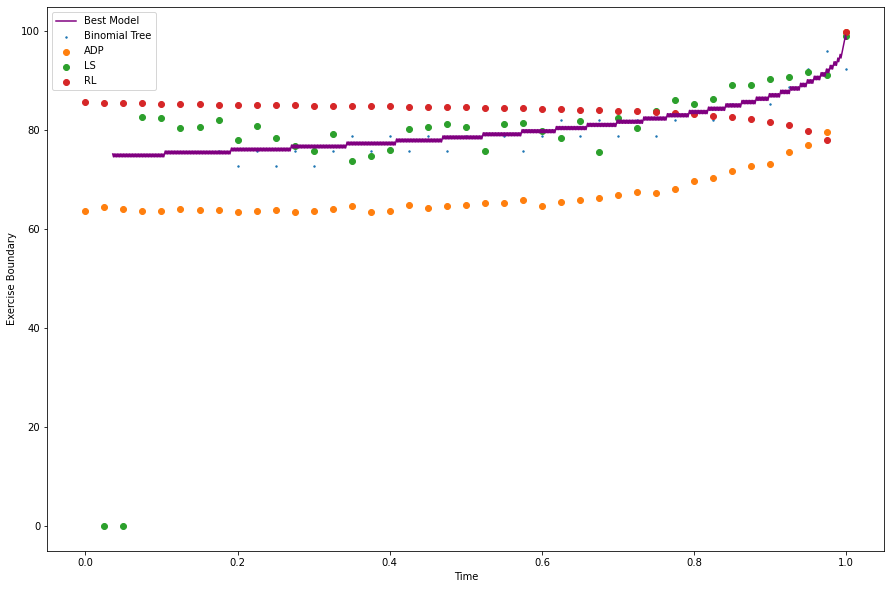

The error on the Bin Tree Optimal Exercise Boundary is: 	2.15039

The error on the ADP Optimal Exercise Boundary is: 	13.11817

The error on the LS Optimal Exercise Boundary is: 	2.23114

The error on the RL Optimal Exercise Boundary is: 	4.89544



In [152]:
# Compare the exercise boundaries and prices

# Black-Scholes
print(f"Black-Scholes European Option Price = {price_bs:.3f}\n")

# for plotting
plt.figure(figsize=(15,10))

# Best model
x_ex_boundary_best, y_ex_boundary_best = zip(*ex_boundary_best)
plt.plot(x_ex_boundary_best, y_ex_boundary_best, label="Best Model", color = "purple")
# print the price of the american option (VF at state 0, at time 0)
# price_best: float = vf_seq_best[0][NonTerminal(0)]
price_best: float = vf_seq_best[0][NonTerminal(0)]
print(f"Best Model American Option Price = {price_best:.3f}\n")

# Binary Tree
x_ex_boundary_bin_tree, y_ex_boundary_bin_tree = zip(*ex_boundary_bin_tree)
plt.scatter(x_ex_boundary_bin_tree, y_ex_boundary_bin_tree, s = 2, label="Binomial Tree")
# print the price of the americ"an option (VF at state 0, at time 0)
# price_bin_tree: float = vf_seq_bin_tree[0][NonTerminal(0)]
price_bin_tree: float = vf_seq_bin_tree[0][NonTerminal(0)]
print(f"Binary Tree American Option Price = {price_bin_tree:.3f}\n")

# ADP
all_funcs: List[FunctionApprox[NonTerminal[float]]] = []
for t, (v_opt, p) in enumerate(it_vf_adp):
    all_funcs.append(v_opt)

price_adp_wo_scoring: float = all_funcs[0](NonTerminal(spot_price_val))

y_ex_boundary_adp: Sequence[float] = opt_ex_adp.put_option_exercise_boundary(
    all_funcs,
    strike_val
)
x_ex_boundary_adp = [t * dt_adp for t in range(0, num_steps_val_adp + 1)]
# y_ex_boundary_adp = ex_boundary_adp
plt.scatter(x_ex_boundary_adp, y_ex_boundary_adp, label="ADP")

print("ADP American Option Price (w\o ind. scoring) = %.5f\n" % price_adp_wo_scoring)
print("ADP American Option Price (w\  ind. scoring) = %.5f\n" % price_adp)

# LS
x_ex_boundary_ls = [t * dt_ls for t in range(1, num_steps_val_ls + 1)]
y_ex_boundary_ls = ex_boundary_ls
plt.scatter(x_ex_boundary_ls, y_ex_boundary_ls, label="LS")
print("Longstaff-Schwartz American Option Price = %.5f\n" % price_ls)

# RL
x_ex_boundary_rl = [i * dt_rl for i in range(num_steps_val_rl + 1)]
y_ex_boundary_rl = ex_boundary_rl
plt.scatter(x_ex_boundary_rl, y_ex_boundary_rl, label="RL")
print(f"RL American Option Price (w\o ind. scoring) = {price_rl_wo_scoring:.3f}\n")
print(f"RL American Option Price (w\  ind. scoring)= {price_rl:.3f}\n")

# show the plot
plt.legend(loc="best")
plt.xlabel("Time")
plt.ylabel("Exercise Boundary")
plt.savefig("C:/Users/frede/OneDrive/Documents/MCF/Autumn 21/CME291/plots/exercise_boundaries_{}_laguerre_{}_reg.png".format(num_laguerre_val,reglr_coeff_val))
plt.show()

# compute the error metric for each of these boundaries
ex_boundary_error_bin_tree = ex_boundary_error_metric(x_ex_boundary_best,
                                                      y_ex_boundary_best,
                                                      x_ex_boundary_bin_tree,
                                                      y_ex_boundary_bin_tree)
print("The error on the Bin Tree Optimal Exercise Boundary is: \t{:.05f}\n".format(ex_boundary_error_bin_tree))

ex_boundary_error_adp = ex_boundary_error_metric(x_ex_boundary_best,
                                                  y_ex_boundary_best,
                                                  x_ex_boundary_adp,
                                                  y_ex_boundary_adp)
print("The error on the ADP Optimal Exercise Boundary is: \t{:.05f}\n".format(ex_boundary_error_adp))

ex_boundary_error_ls = ex_boundary_error_metric(x_ex_boundary_best,
                                                  y_ex_boundary_best,
                                                  x_ex_boundary_ls,
                                                  y_ex_boundary_ls)
print("The error on the LS Optimal Exercise Boundary is: \t{:.05f}\n".format(ex_boundary_error_ls))

ex_boundary_error_rl = ex_boundary_error_metric(x_ex_boundary_best,
                                                  y_ex_boundary_best,
                                                  x_ex_boundary_rl,
                                                  y_ex_boundary_rl)
print("The error on the RL Optimal Exercise Boundary is: \t{:.05f}\n".format(ex_boundary_error_rl))

In [153]:
# comprare the execution times
print("The execution time of the Best model is: \t{:.05f} seconds".format(time_best))
print("The execution time of the Bin Tree model is: \t{:.08f} seconds".format(time_bin_tree))
print("The execution time of the ADP model is: \t{:.05f} seconds".format(time_adp))
print("The execution time of the LS model is: \t{:.05f} seconds".format(time_ls))
print("The execution time of the RL model is: \t{:.05f} seconds".format(time_rl))

The execution time of the Best model is: 	23.27631 seconds
The execution time of the Bin Tree model is: 	0.03986025 seconds
The execution time of the ADP model is: 	114.50641 seconds
The execution time of the LS model is: 	12.26535 seconds
The execution time of the RL model is: 	105.91969 seconds


Time step: 0.00 out of 1.00


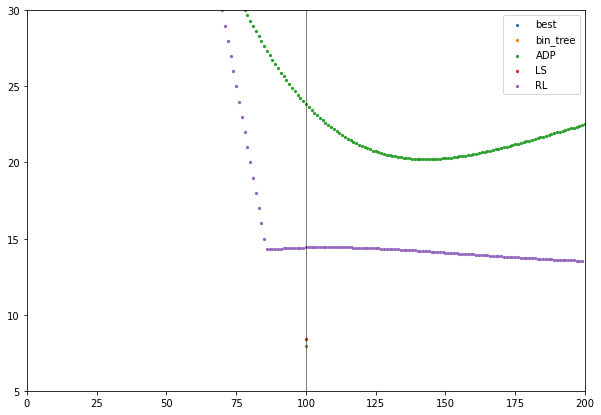

Time step: 0.20 out of 1.00


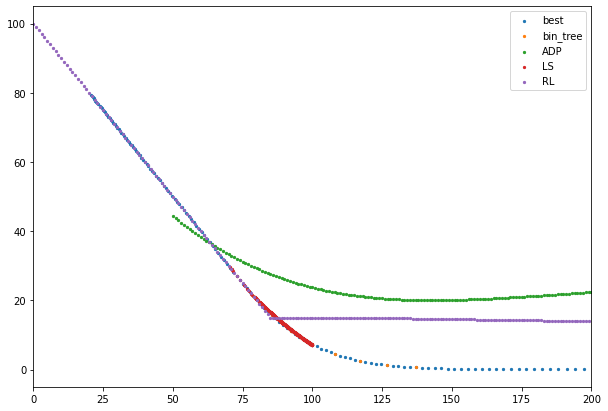

Time step: 0.40 out of 1.00


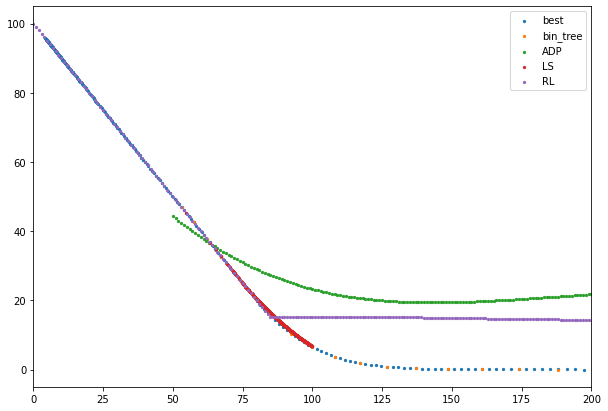

Time step: 0.60 out of 1.00


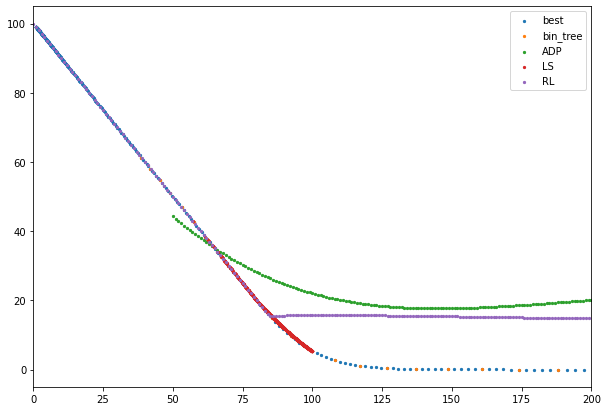

Time step: 0.80 out of 1.00


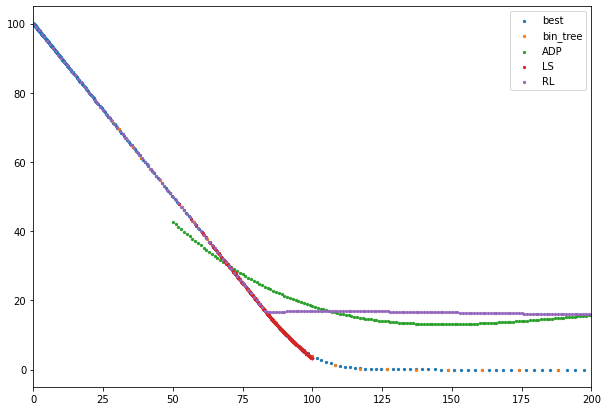

Time step: 1.00 out of 1.00


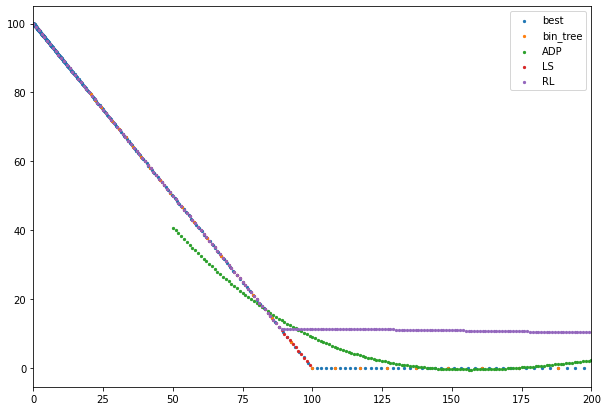

In [154]:
# Compare the Optimal Value Functions at each 20% time steps

# Best
x_best = []
y_best = []
skip_best = int(skip_size_val * num_steps_val_best)
for i in range(num_steps_val_best+1):
    if i%skip_best == 0:
        y_best.append([vf_seq_best[i][NonTerminal(j)] for j in range(len(vf_seq_best[i]))])
        x_best.append([opt_ex_best.state_price(i,j) for j in range(len(vf_seq_best[i]))])


# Binary Tree
x_bin_tree = []
y_bin_tree = []
skip_bin_tree = int(skip_size_val * num_steps_val_bin_tree)
for i in range(num_steps_val_bin_tree+1):
    if i%skip_bin_tree == 0:
        y_bin_tree.append([vf_seq_bin_tree[i][NonTerminal(j)] for j in range(len(vf_seq_bin_tree[i]))])
        x_bin_tree.append([opt_ex_bin_tree.state_price(i,j) for j in range(len(vf_seq_bin_tree[i]))])
        
# ADP
x_adp = []
y_adp = []
prices: np.ndarray = np.arange(50,250.0)
skip_adp = int(skip_size_val * num_steps_val_adp)
for i in range(len(it_vf_adp)):
    if i%skip_adp == 0:
        v_opt, p = it_vf_adp[i]
        v_opt_curve: np.ndarray = opt_ex_adp.optimal_value_curve(
            func=v_opt,
            prices=prices
        )
        x_adp.append(prices)
        y_adp.append(v_opt_curve)
        
# LS
x_ls = []
y_ls = []
skip_ls = int(skip_size_val * num_steps_val_ls)
for i in range(num_steps_val_ls+1):
    if i%skip_ls == 0:
        x,y = zip(*vf_seq_ls[i])
        x_ls.append(x)
        y_ls.append(y)
        
# RL
x_rl = []
y_rl = []
skip_rl = int(skip_size_val * num_steps_val_rl)
for i in range(num_steps_val_rl+1):
    if i%skip_rl == 0:
        x,y = zip(*vf_seq_rl[i])
        x_rl.append(x)
        y_rl.append(y)

# plot them all together
for i in range(int(1.0 / skip_size_val) + 1):        
    print("Time step: {:.02f} out of {:.02f}".format(i * skip_size_val * expiry_val, expiry_val))
    plt.figure(figsize=(10,7))
    plt.scatter(x_best[i],y_best[i],s=5,label="best")
    plt.scatter(x_bin_tree[i],y_bin_tree[i],s=5,label="bin_tree")
    plt.scatter(x_adp[i],y_adp[i],s=5,label="ADP")
    plt.scatter(x_ls[i],y_ls[i],s=5,label="LS")
    plt.scatter(x_rl[i],y_rl[i],s=5,label="RL")
    plt.legend(loc="best")
    plt.xlim(0,200)
    if i == 0:
        plt.axvline(spot_price_val,color="black",linewidth=.5)
        plt.ylim(5,30)
    plt.savefig("C:/Users/frede/OneDrive/Documents/MCF/Autumn 21/CME291/plots/value_functions_{}_expiry_{}_laguerre_{}_reg.png".format(i,num_laguerre_val,reglr_coeff_val))
    plt.show()
    
        